# Third Exercise (Chapter 7 & 8)
This exercise focuses on optimization and regularization.

In the optimization part, we will
- implement the Adam optimizer
- compare Adam, SGD, SGD with Momentum
- implement and analyze some learning rate schedules

In the regularization part, we will
- implement Dropout
- implement L1/L2 loss
- analyze the effect of the different regularization methods on the parameter distribution.
- think about early stopping and data augmentation

You can **reuse the code you wrote in the last exercise, or you can use the code we provide (below)**. Just copy the relevant parts into the cell below. Please **note that we extended the `Module` class** with a state to determine whether we're training or evaluating and two functions to toggle this state. We therefore also adapted the training loop function.

The first task of this exercise is to implement Adam, you can **skip forward to the exercises by clicking [here](#adam)**.

### Base classes: `Parameter` and `Module`

In [1]:
from typing import Iterable, List, Optional, Tuple, Callable
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores th_solution-Copy1e value of the parameter but also tensors/
    properties associated with it, such as the gradient of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, name: Optional[str] = None):
        self.data = data
        self.grad = None
        self.name = name
        self.state_dict = dict()  # dict to store additional, optional information


class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None
        self.training = True

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def train(self, mode : bool = True) -> 'Module':
        """Set the module to training mode.

        This only affects some Modules, such as Dropout.
        
        Returns:
            self.
        """
        self.training = mode
        return self

    def eval(self) -> 'Module':
        """Set the module to evaluation mode.

        This only affects some Modules, such as Dropout.

        Returns:
            self.
        """
        return self.train(False)

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))



### Activation functions: `Relu` and `Softmax`

In [3]:
class Softmax(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        # Shift input for numerical stability.
        reduction_axes = tuple(range(1, len(z.shape)))
        shift_z = z - np.max(z, axis=reduction_axes, keepdims=True)
        exps = np.exp(shift_z)
        h = exps / np.sum(exps, axis=reduction_axes, keepdims=True)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


class Relu(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        return np.maximum(0, z)

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        return grad.reshape(z.shape) * np.where(z > 0, 1, 0)

### Layers

In [4]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.W = Parameter(np.random.randn(out_features, in_features) * 0.01,
                           name="W")
        self.b = Parameter(np.ones((out_features, 1)) * 0.01, name="b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        z = self.W.data @ x + self.b.data
        return z

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that we have a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of array.T
        self.W.grad += np.sum(grad @ np.transpose(x, [0, 2, 1]), axis=0)
        self.b.grad += np.sum(grad, axis=0)
        return self.W.data.T @ grad

    def parameters(self) -> List[Parameter]:
        return self.W, self.b


class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        for module in self.modules:
            x = module(x)  # equivalent to module.forward(x)
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        for module in reversed(self.modules):
            grad = module.backward(grad)
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]
    
    def train(self, mode: bool = True) -> 'Sequential':
        """Set the train mode of the Sequential module and it's sub-modules.
        
        This only affects some modules, e.g., Dropout.
        
        Returns:
            self.
        """
        for module in self.modules:
            module.train(mode)
        return self


def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 2]]
    """
    encoded = np.zeros(y.shape + (num_classes,))
    encoded[np.arange(len(y)), y] = 1
    return encoded

### Optimizers

In [5]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)


class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # update the momentum
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                # update the parameter
                p.data += p.state_dict["momentum"]
            else:
                p.data -= self.lr * p.grad

### Loss Functions


In [6]:
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        grad = (a - y) / len(a)

        # We have to recreate the batch dimension
        grad = np.expand_dims(grad, -1)
        return grad

### Training loops

In [7]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, loss_fn, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, scheduler=None):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        model.train()
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            optimizer.zero_grad()
            y_batch_predicted = model(x_batch)
            h_1 = np.squeeze(y_batch_predicted)
            training_predictions.append(h_1)
            loss = loss_fn(h_1, y_batch)
            grad = loss_fn.backward()
            model.backward(grad)
            optimizer.step()
            train_costs[epoch] += loss
        if scheduler:
            scheduler.step()
        model.eval()
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, loss_fn, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

### Data Loading

In [8]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

## Optimization

<a id='adam'></a>
### Adam
**Implement the step function** of the adam optimizer.

In [9]:
class Adam(Optimizer):

    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08):
        super().__init__(params)
        # we stick to the pytorch API, the variable names corresponding
        # to the DL book are given in the comments
        self.lr = lr  # lr is called epsilon in the DL book
        self.betas = betas  # betas are called rho in the DL book
        self.eps = eps  # eps is called delta in the DL book
        self.t = 0
        for param in self._params:
            # first order moment variables, called m in the paper
            param.state_dict["s"] = np.zeros_like(param.data)
            # second order moment variables, called v in the paper
            param.state_dict["r"] = np.zeros_like(param.data)

    def step(self) -> None:
        """Update the parameters and decaying averages of past gradients."""
        # START ################
        self.t += 1
        b1, b2 = self.betas
        for p in self._params:
            p.state_dict['s'] = b1 * p.state_dict['s'] + (1-b1) * p.grad
            p.state_dict['r'] = b2 * p.state_dict['r'] + (1-b2) * (p.grad * p.grad)
            s_cap = p.state_dict['s'] / (1 - b1**self.t)
            r_cap = p.state_dict['r'] / (1 - b2**self.t)
            
            p.data -= (self.lr * s_cap) / (self.eps + np.sqrt(r_cap))
            
        # END ###################


### Compare: Adam vs SGD vs SGD with Momentum

**Train three models** (30 hidden units, relu) for 10 epochs, one with *Adam*, one with *SGD* and one with *SGD with momentum*. 

In [10]:
linear_units = 30
batch_size = 50
num_epochs = 10
sgd_learning_rate = 0.1
momentum = 0.9
adam_learning_rate = 0.01

# START ################

# SGD
print('Start SGD\n')
sgd_model = Sequential(Linear(784, linear_units), Relu(), Linear(linear_units, 10))

loss_fn = CrossEntropyLoss()
optimizer = SGD(sgd_model.parameters(), lr=sgd_learning_rate)
   
sgd_train_costs, sgd_train_accuracies, sgd_eval_costs, sgd_eval_accuracies =\
    train(sgd_model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)

    
# SGD momentum
print('\nStart SGD with momentum\n')
sgdm_model = Sequential(Linear(784, linear_units), Relu(), Linear(linear_units, 10))

loss_fn = CrossEntropyLoss()
optimizer = SGD(sgdm_model.parameters(), lr=sgd_learning_rate, momentum=momentum)
   
sgdm_train_costs, sgdm_train_accuracies, sgdm_eval_costs, sgdm_eval_accuracies =\
    train(sgdm_model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)
    
    
# Adam
print('\nStart Adam\n')
adam_model = Sequential(Linear(784, linear_units), Relu(), Linear(linear_units, 10))

loss_fn = CrossEntropyLoss()
optimizer = Adam(adam_model.parameters(), lr=adam_learning_rate)
   
adam_train_costs, adam_train_accuracies, adam_eval_costs, adam_eval_accuracies =\
    train(adam_model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)

# END ###################

Start SGD

Epoch 1 / 10:
  Training Accuracy: 0.8295
  Training Cost: 593.1893
  Eval Accuracy: 0.9217
Epoch 2 / 10:
  Training Accuracy: 0.9226
  Training Cost: 267.9423
  Eval Accuracy: 0.9405
Epoch 3 / 10:
  Training Accuracy: 0.9378
  Training Cost: 214.9782
  Eval Accuracy: 0.9470
Epoch 4 / 10:
  Training Accuracy: 0.9465
  Training Cost: 184.0142
  Eval Accuracy: 0.9511
Epoch 5 / 10:
  Training Accuracy: 0.9529
  Training Cost: 162.4902
  Eval Accuracy: 0.9571
Epoch 6 / 10:
  Training Accuracy: 0.9575
  Training Cost: 146.3333
  Eval Accuracy: 0.9580
Epoch 7 / 10:
  Training Accuracy: 0.9615
  Training Cost: 132.6136
  Eval Accuracy: 0.9595
Epoch 8 / 10:
  Training Accuracy: 0.9652
  Training Cost: 121.7998
  Eval Accuracy: 0.9635
Epoch 9 / 10:
  Training Accuracy: 0.9676
  Training Cost: 111.2734
  Eval Accuracy: 0.9640
Epoch 10 / 10:
  Training Accuracy: 0.9699
  Training Cost: 104.0346
  Eval Accuracy: 0.9633

Start SGD with momentum

Epoch 1 / 10:
  Training Accuracy: 0.8899


**Create two plots**, one for the training loss curves and one for the training accuracies curves.

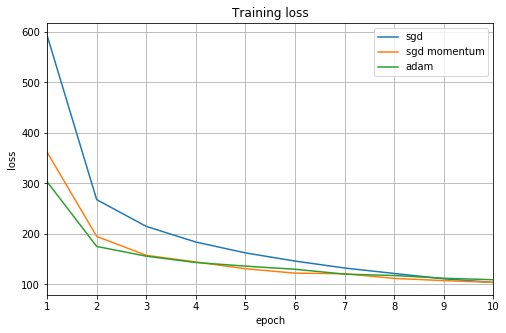

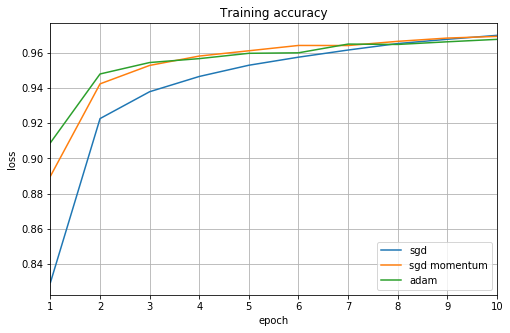

In [11]:
import matplotlib.pyplot as plt 
#% matplotlib inline

# START ################
num_epochs = 10
x = np.arange(1, num_epochs+1)
#print(x)
# training loss

plt.figure(figsize=(8, 5))
plt.plot(x, sgd_train_costs, label='sgd')
plt.plot(x, sgdm_train_costs, label='sgd momentum')
plt.plot(x, adam_train_costs, label='adam')

plt.grid(True)
plt.margins(0, 0.05)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.title("Training loss")

plt.legend()

plt.show()

# training accuracy
plt.figure(figsize=(8,5))
plt.plot(x, sgd_train_accuracies, label='sgd')
plt.plot(x, sgdm_train_accuracies, label='sgd momentum')
plt.plot(x, adam_train_accuracies, label='adam')

plt.grid(True)
plt.margins(0, 0.05)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(ymax=1)

plt.title("Training accuracy")

plt.legend()

plt.show()

# END ###################

### Learning Rate Schedules

Decreasing the learning rate can improve performance of the model.

Pytorch implements learning rate schedules as wrappers for the optimizer and requires the user to call scheduler.step() after each epoch. (We've already done this for you in the training loop above)

**Implement the learning rate scheduler** `PieceWiseConstantLR` and `CosineAnnealingLR`. You can use the provided `LambdaLR` class for this, which works analogously to the pytorch [LambdaLR](https://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.LambdaLR)


In [12]:
class LambdaLR:

    def __init__(self, optimizer: Optimizer, lr_lambda: Callable[[int], float]):
        """Sets the learning rate to the initial lr times a given function.

        Args:
            optimizer: The optimzier to wrap.
            lr_lambda: A function that takes the current epoch as an argument
                and returns the corresponding learning rate.
        """
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        self.last_epoch = 0
        self.initial_lr = np.copy(optimizer.lr)
        self.lr_lambda = lr_lambda

    def step(self):
        """To be called after each epoch. Update optimizer.lr"""
        self.last_epoch += 1
        self.optimizer.lr = self.lr_lambda(self.last_epoch)


class PiecewiseConstantLR(LambdaLR):

    def __init__(self, optimizer: Optimizer, epochs: List[int],
                 learning_rates: List[float]):
        """Set learning rate as piecewise constant steps.

        This class inherits from LambdaLR and implements the lambda
        function that maps the current epoch to the learning rate
        according to epochs.
        
        optimizer: The optimizer to wrap
        """
        # START ################
        
        self.optimizer = optimizer
        self.last_epoch = 0
        self.initial_lr = np.copy(optimizer.lr)  
        
        self.epochs = epochs
        self.lrs = learning_rates
        
        self.lr_lambda = lambda ep: self.lrs[self.epochs.index(ep)] if ep in self.epochs else self.optimizer.lr
        
        # End ################
        
        
class CosineAnnealingLR(LambdaLR):

    def __init__(self, optimizer: Optimizer, T_max: int):
        """Set learning rate as a cosine decay.

        This class inherits from LambdaLR and implements the lambda
        function that maps the current epoch to the learning rate
        according to epochs.
        
        optimizer: The optimizer to wrap
        T_max:  Maximum number of epochs.
        """
        # START ################
        self.optimizer = optimizer
        self.last_epoch = 0
        self.initial_lr = np.copy(optimizer.lr)  
        
        self.tmax = T_max
        
        self.lr_lambda = lambda ep: 0.5 * (1 + np.cos( (ep/self.tmax) * np.pi)) * self.initial_lr
        
        # End ################

To verify your implementation, **plot the learning rate schedules**, with the number of epochs on the x-axis and the learning rate on the y-axis.

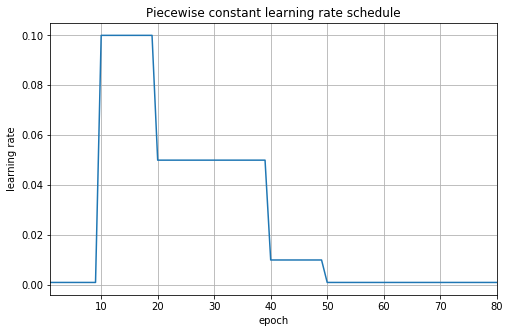

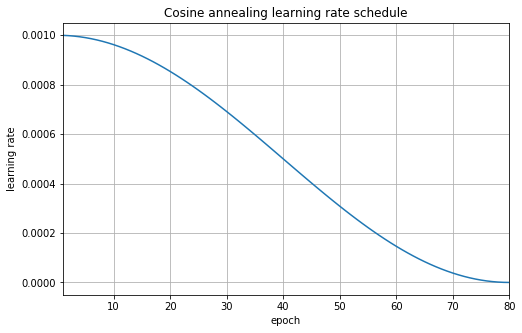

In [13]:
num_epochs = 80

optimizer = Adam([])
piecewise_scheduler = PiecewiseConstantLR(optimizer, [10, 20, 40, 50], [0.1, 0.05, 0.01, 0.001])

optimizer = Adam([])
cosine_scheduler = CosineAnnealingLR(optimizer, num_epochs)

# START ################
x = np.arange(1, num_epochs+1)

# plot piecewise lr
p = []
c = []
for i in range(0,80,1):
    piecewise_scheduler.step()
    p.append(piecewise_scheduler.optimizer.lr)
    
    cosine_scheduler.step()
    c.append(cosine_scheduler.optimizer.lr)
    

plt.figure(figsize=(8,5))
plt.plot(x, p)

plt.grid(True)
plt.margins(0,0.05)
plt.xlabel('epoch')
plt.ylabel('learning rate')

plt.title("Piecewise constant learning rate schedule")

plt.show()

# plot cosine lr
plt.figure(figsize=(8,5))
plt.plot(x, c)

plt.grid(True)
plt.margins(0, 0.05)
plt.xlabel('epoch')
plt.ylabel('learning rate')

plt.title("Cosine annealing learning rate schedule")

plt.show()
# End ################

### Your Feedback on Exercise 3.1

We invested about 2h for this exercise. It was good to see how the different optimizers and learning rate schedulers behave during training.

## Regularization

In this part of the exercise we will take a look multiple regularizers.

### Dropout
**Fill in the missing gaps** for the implementation of the dropout regularization (Chapter 7.12 in the DL book).
During training, the dropout layer randomly sets the input tensor to 0 with probability p and scales the remaining values accordingly. During evaluation, the dropout layer returns the identity.


In [14]:
class Dropout(Module):
    """Set input elements to zero during training with probability p."""

    def __init__(self, p : float = 0.5, fix_seed=False):
        """
        Args:
            p: Probability of an element to be zeroed. Default: 0.5.
            fix_seed: If true, we always use the same seed in the forward pass.
                This is only needed for gradient checking and should only be
                set True for gradient checking.
        """
        super().__init__()
        self.p = p
        # START ################
        self.scale = 1/(1-self.p)
        # END ################
        self.fix_seed = fix_seed

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Apply dropout during training.
        
        Set values to zero with probability p during training
        and scale them by 1/(1-p). Returns identidy during
        evaluation mode (--> self.training = False).

        Note: This layer should work with all kinds of input shapes.
        """ 
        if not self.training:
            return x
        if self.fix_seed:  # we need this for gradient checking 
            np.random.seed(0)
        # START ################
        u = np.random.binomial(1, self.p, size=x.shape) * self.scale
        out = x * u
        self.input_cache = u
        return out
        # END ################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        if not self.training:
            raise ValueError("Model is set to evaluation mode.")
        # START ################
        grad_output = grad * self.input_cache
        return grad_output
        # END ################

# Check the gradient implementation
x = np.random.rand(1, 1, 4, 4)
Dropout(fix_seed=True).check_gradients((x,))


### L1/L2 regularization
**Implement $L_1$/$L_2$ regularization**. This is one of the rare cases where we differ from the pytorch API. The reason is that pytorch implements $L_2$ regularization in the optimizer but calles it `weight_decay` (which is actually a different operation if you're not using SGD).


In [15]:
class L1Regularization(Module):

    def __init__(self, alpha: float, parameters: List[Parameter]):
        super().__init__()
        self.alpha = alpha
        self.params = parameters

    def forward(self) -> np.ndarray:
        # START ################
        sum_weights = 0
        for p in self.params:
            sum_weights += np.sum(np.absolute(p.data))
        l1 = self.alpha * sum_weights
        return l1
        # END ################

    def backward(self, _=None):           
        # START ################
        for p in self.params:
            p.grad = p.grad + self.alpha * np.sign(p.data)
        # END ################

    def parameters(self) -> List[Parameter]:
        return self.params


class L2Regularization(Module):

    def __init__(self, alpha: float, parameters: List[Parameter]):
        super().__init__()
        self.alpha = alpha
        self.params = parameters

    def forward(self) -> np.ndarray:    
        # START ################
        sum_weights = 0
        for p in self.params:
            sum_weights += np.sum(p.data * p.data)
        l2 = (self.alpha / 2) * sum_weights
        return l2
        # END ################

    def backward(self, _=None):       
        # START ################
        for p in self.params:
            p.grad = p.grad + self.alpha * p.data
        # END ################

    def parameters(self) -> List[Parameter]:
        return self.params


# Check the gradient implementation. Here we can only check w.r.t. the parameters.
params = [Parameter(np.random.rand(50, 1) * 0.1)]
l2 = L2Regularization(0.1, params)
l1 = L1Regularization(0.1, params)
l2.check_gradients_wrt_params((), 1e-6)
l1.check_gradients_wrt_params((), 1e-6)


class RegularizedCrossEntropy(Module):
    """Combines Cross Entropy loss and Regularization loss by summing them."""
    
    def __init__(self, regularization_loss: Module):
        self.reg_loss = regularization_loss
        self.cross_entropy = CrossEntropyLoss()
        
    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.cross_entropy(a, y) + self.reg_loss()
        
    def backward(self, _=None) -> np.ndarray:
        self.reg_loss.backward()  # this updates parameter gradients, no grad w.r.t input
        return self.cross_entropy.backward()
    

Let's now visualize the effect of regularization on the model parameters.
We'll do that with **four trained models**:
1. Without regularization. It's always a good idea to train your model without any regularization first. Not only to have a baseline but also to check if your model is able to overfit the training data. If it can't overfit, it's likely not powerful enough or there's an error in the implementation. 
2. With L2 regularization, alpha = 0.0001, on the weight parameters (not on the bias)
3. With L1 regularization, alpha = 0.0001, on the weight parameters (not on the bias)
4. With Dropout, drop_probability = 0.3 for the input, drop_probability = 0.5 for the hidden layers.

*Note* that in this case L1/L2/Dropout lead to worse accuracies. This is due to the fact that we use only 30 linear units to keep training times short, which already imposes strong regularization. In practice, we would select a more powerful model. However, the small model still nicely exhibits the effect of regularization on the distribution of the parameters.

In [16]:
num_epochs = 5
batch_size = 50
learning_rate = 0.05
momentum = 0.9
linear_units = 30
alpha_l1 = 0.0001
alpha_l2 = 0.0001

def build_model():
    return Sequential(Linear(784, linear_units),
                      Relu(),
                      Linear(linear_units, 10))


def build_model_dropout():
    return Sequential(Dropout(0.3),
                      Linear(784, linear_units),
                      Relu(),
                      Dropout(0.5),
                      Linear(linear_units, 10))

models = {}  # dict to store the trained models
# let's save a model, which we won't train, to get the initial parameter distribution
models["before_training"] = build_model()

# no regularization
print("No regularization.")
models["no_reg"] = build_model()
params_noreg = [p for p in models["no_reg"].parameters() if "W" in p.name]
cross_entropy = CrossEntropyLoss()
optimizer = SGD(models["no_reg"].parameters(), lr=learning_rate, momentum=momentum)
train(models["no_reg"], cross_entropy, optimizer, x_train, y_train,
      x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)

# START ################


# L2 regularization
print("L2 regularization.")
models["l2"] = build_model()
params_l2 = [p for p in models["l2"].parameters() if "W" in p.name]
l2_loss = RegularizedCrossEntropy(L2Regularization(alpha_l2, params_l2))
optimizer = SGD(models["l2"].parameters(), lr=learning_rate, momentum=momentum)
train(models["l2"], l2_loss, optimizer, x_train, y_train,
      x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)


# L1 regularization
print("L1 regularization.")

models["l1"] = build_model()
params_l1 = [p for p in models["l1"].parameters() if "W" in p.name]
l1_loss = RegularizedCrossEntropy(L1Regularization(alpha_l1, params_l1))
optimizer = SGD(models["l1"].parameters(), lr=learning_rate, momentum=momentum)
train(models["l1"], l1_loss, optimizer, x_train, y_train,
      x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)



# dropout
print("Dropout.")
models["drop"] = build_model_dropout()
params_drop = [p for p in models["drop"].parameters() if "W" in p.name]
cross_entropy = CrossEntropyLoss()
optimizer = SGD(models["drop"].parameters(), lr=learning_rate, momentum=momentum)
train(models["drop"], cross_entropy, optimizer, x_train, y_train,
      x_val, y_val, num_epochs=num_epochs, batch_size=batch_size)


# END ################
pass

No regularization.
Epoch 1 / 5:
  Training Accuracy: 0.8794
  Training Cost: 387.9068
  Eval Accuracy: 0.9450
Epoch 2 / 5:
  Training Accuracy: 0.9469
  Training Cost: 180.2697
  Eval Accuracy: 0.9553
Epoch 3 / 5:
  Training Accuracy: 0.9567
  Training Cost: 143.8424
  Eval Accuracy: 0.9579
Epoch 4 / 5:
  Training Accuracy: 0.9622
  Training Cost: 126.1778
  Eval Accuracy: 0.9630
Epoch 5 / 5:
  Training Accuracy: 0.9659
  Training Cost: 111.7027
  Eval Accuracy: 0.9612
L2 regularization.
Epoch 1 / 5:
  Training Accuracy: 0.8818
  Training Cost: 383.5087
  Eval Accuracy: 0.9462
Epoch 2 / 5:
  Training Accuracy: 0.9460
  Training Cost: 190.2765
  Eval Accuracy: 0.9503
Epoch 3 / 5:
  Training Accuracy: 0.9556
  Training Cost: 161.8806
  Eval Accuracy: 0.9542
Epoch 4 / 5:
  Training Accuracy: 0.9611
  Training Cost: 145.7584
  Eval Accuracy: 0.9642
Epoch 5 / 5:
  Training Accuracy: 0.9655
  Training Cost: 133.8418
  Eval Accuracy: 0.9618
L1 regularization.
Epoch 1 / 5:
  Training Accuracy:

Let's now compare the parameter distribution of the four models by **plotting the histogram of their weight values from -1 to 1 with 100 bins**. 

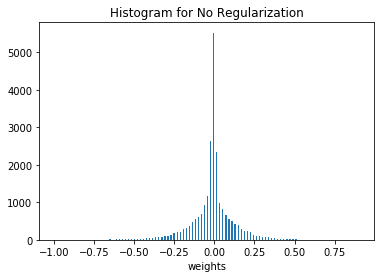

In [62]:
# START TODO ################
res_noreg = []
for p in params_noreg:
    select_noreg = p.data[np.logical_and(p.data >= (-1.0), p.data <= 1.0)]
    res_noreg.append(select_noreg)
    
plt.hist(res_noreg, bins=100)
plt.xlabel('weights')
plt.title('Histogram for No Regularization')
plt.show()
# End TODO ################

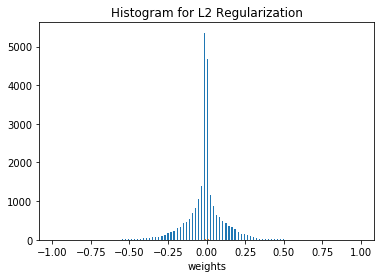

In [63]:
# START TODO ################
res_l2 = []
for p in params_l2:
    select_l2 = p.data[np.logical_and(p.data >= (-1.0), p.data <= 1.0)]
    res_l2.append(select_l2)
    
plt.hist(res_l2, bins=100)
plt.xlabel('weights')
plt.title('Histogram for L2 Regularization')
plt.show()
# End TODO ################

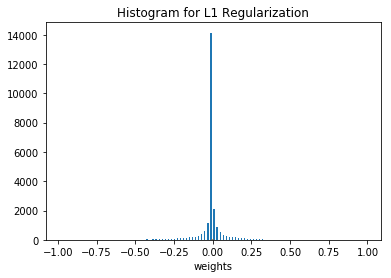

In [64]:
# START TODO ################
res_l1 = []
for p in params_l1:
    select_l1 = p.data[np.logical_and(p.data >= (-1.0), p.data <= 1.0)]
    res_l1.append(select_l1)
plt.hist(res_l1, bins=100)
plt.xlabel('weights')
plt.title('Histogram for L1 Regularization')
plt.show()
# End TODO ################

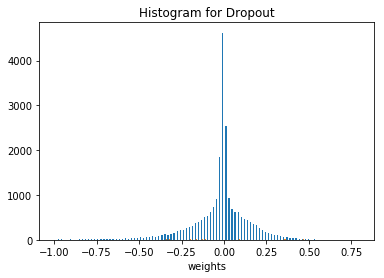

In [68]:
# START TODO ################
res_drop = []
for p in params_drop:
    select_drop = p.data[np.logical_and(p.data >= (-1.0), p.data <= 1.0)]
    res_drop.append(select_drop)

plt.hist(res_drop, bins=100)
plt.xlabel('weights')
plt.title('Histogram for Dropout')
plt.show()
# End TODO ################

## Data Augmentation

Data augmentation increases model generalization by increasing the training set with fake data.

**Question:** State *five effective operations* to generate fake data on the *MNIST dataset*. State *one operation* which doesn't make sense and why.

**Answer:** 
- generate additional images through: Image Translation, Scaling, Reflection, Rotation, Stretching 
- Reflection makes no sense, because it changes the numbers to much; we could not recognize the numbers anymore.

## Early Stopping

Another very popular technique in deep learning is *early stopping* (deeplearning book, section 7.8). 

![Figure 7.3 from the DeepLearningBook](learning-curve-dl-fig-7-3.png "TEST")

**Questions:**
How do the given loss curves (deep learning book, figure 7.3) relate to *early stopping*?
Why is it a regularization technique? 

**Answers:**
- In the Figure, it is obvious that we could stop learning after a few (maybe 10) epochs; we just have to find the point in which the validation error has reached its minimum. 
- Early Stopping limits the Overfitting problem to get a better generalization. That's the main goal of regularization.

### Your Feedback on Exercise 3.2
We invested about 4h in this exercise. It was a good repetition of the lecture. It was helpful to have more notes like in the last exercise. (For example the note about the worse accuracies for dropout)